In [24]:
import os
from itertools import product
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [2]:
root='./rebuild_dataset'
sz = np.load(f'{root}/sz_oleg.npz')['sz_data'].astype(np.float32)
print('sz.shape', sz.shape)
wo_sz = np.load(f'{root}/wo_sz_oleg.npz')['sz_data'].astype(np.float32)
print('wo_sz.shape', wo_sz.shape)

sz.shape (1000, 5, 256, 256)
wo_sz.shape (1010, 5, 256, 256)


In [3]:
def train_val_test_split(data, val_size=0.15, test_size=0.15, random_state=9):
    assert val_size + test_size < 1
    val_test_size = val_size + test_size
    test_relative_size = test_size / val_test_size
    
    indices = range(data.shape[0])
    train_indices, test_indices = train_test_split(indices, test_size=val_test_size, random_state=random_state)
    val_indices, test_indices = train_test_split(test_indices, test_size=test_relative_size,
                                                 random_state=random_state)
    
    return data[train_indices], data[val_indices], data[test_indices]
  

def crop_center_or_pad(img, new_side):
    _, y, x = img.shape
    if x > new_side:
        startx = x//2-(new_side//2)
        return img[:, startx:startx+new_side,startx:startx+new_side]
    elif x < new_side:
        padx = (new_side//2) - x//2
        return np.pad(img, ((0,), (padx,), (padx,)), mode='constant', constant_values=-1)
    return img

#simple image scaling to (nR x nC) size
def scale_nearest(im, nR, nC):
    nR0 = len(im)     # source number of rows 
    nC0 = len(im[0])  # source number of columns 
    return np.array([[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]  
             for c in range(nC)] for r in range(nR)])

In [4]:
class Planck(Dataset):
    frequencies = ['100', '143', '217', '353', '545']
    
    def __init__(self, sz, wo_sz, split='None'):
        self.is_train = split == 'train'
        
        # 70/15/15
        sz_train, sz_val, sz_test = train_val_test_split(sz)
        wosz_train, wosz_val, wosz_test = train_val_test_split(wo_sz)
        
        if split == 'train':
            self.X = np.concatenate((sz_train, wosz_train), axis=0)
            self.y = np.array([1] * sz_train.shape[0] + [0] * wosz_train.shape[0], dtype=np.uint8)
        elif split == 'val':
            self.X = np.concatenate((sz_val, wosz_val), axis=0)
            self.y = np.array([1] * sz_val.shape[0] + [0] * wosz_val.shape[0], dtype=np.uint8)
        elif split == 'train_val':
            self.X = np.concatenate((sz_train, sz_val, wosz_train, wosz_val), axis=0)
            self.y = np.array([1] * (sz_train.shape[0] + sz_val.shape[0]) + \
                              [0] * (wosz_train.shape[0] + wosz_val.shape[0]), dtype=np.uint8)
        elif split == 'test':
            self.X = np.concatenate((sz_test, wosz_test), axis=0)
            self.y = np.array([1] * sz_test.shape[0] + [0] * wosz_test.shape[0], dtype=np.uint8)
        else:
            raise Exception()
            
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        X, y = self.X[idx], self.y[idx]

        X = X[:, ::2, ::2]
        X = crop_center_or_pad(X, 128)
        return torch.from_numpy(X), y

# Train

In [5]:
device = 0
name = 'forest'
batch_size = 50
n_epochs = 150

In [7]:
train_dataset, val_dataset, test_dataset = Planck(sz, wo_sz, split='train'), Planck(sz, wo_sz, split='val'), \
                                           Planck(sz, wo_sz, split='test')
train_val_dataset = Planck(sz, wo_sz, split='train_val')

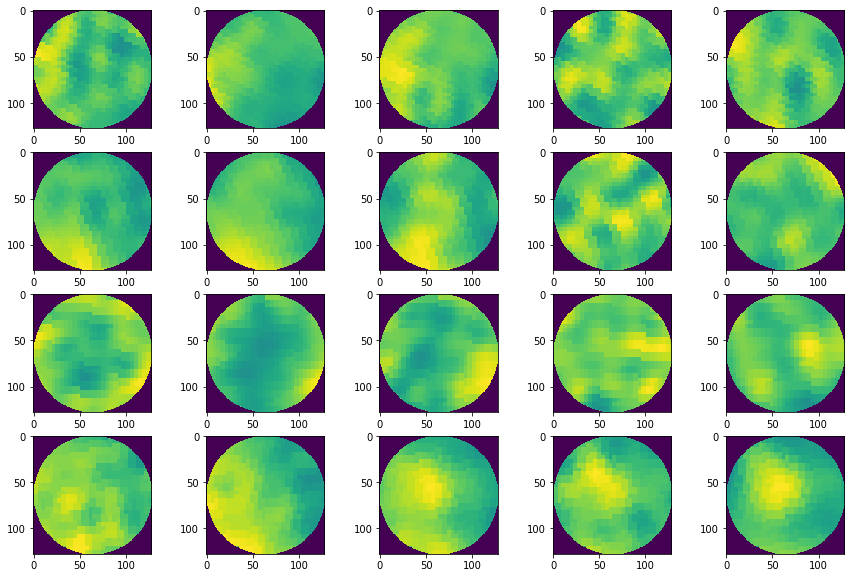

In [8]:
img_effect_1, _ = train_dataset.__getitem__(0)
img_effect_2, _ = train_dataset.__getitem__(4)
img_no_effect_1, _ = train_dataset.__getitem__(300)
img_no_effect_2, _ = train_dataset.__getitem__(304)

fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for i in range(5):
    ax[0][i].imshow(img_effect_1[i])
    ax[1][i].imshow(img_effect_2[i])
    ax[2][i].imshow(img_no_effect_1[i])
    ax[3][i].imshow(img_no_effect_2[i])

In [9]:
def prepare_features(train_dataset):
    train2_X, train2_y = [], []
    for X, y in train_dataset:
        features = []
        for i in range(5):
            pixels = X[i][X[i] != -1]
            a, b = np.histogram(pixels, bins=5, range=(0, 0.5))
            features.extend([
                pixels.max(),
                pixels.mean(),
                pixels.std()
            ] + a.tolist())
        for i in range(5):
            for j in range(i + 1, 5):
                pixels = X[i][X[i] != -1] - X[j][X[j] != -1]
                a, b = np.histogram(pixels, bins=5, range=(0, 0.5))
                features.extend([
                    pixels.max(),
                    pixels.mean(),
                    pixels.std()
                ] + a.tolist())
        train2_X.append(features)
        train2_y.append(y)
    return train2_X, train2_y

train2_X, train2_y = prepare_features(train_dataset)
val2_X, val2_y = prepare_features(val_dataset)
test2_X, test2_y = prepare_features(test_dataset)
cv2_X, cv2_y = prepare_features(train_val_dataset)

In [12]:
def calc_set(params_set):
    acc_cv = cross_validate(RandomForestClassifier(**params_set), cv2_X, cv2_y, cv=5, n_jobs=1)
    acc_mean = np.mean(acc_cv['test_score'])
    return params_set, acc_mean

params = {
    'n_estimators': [300],
    'criterion': ['entropy'],
    'max_depth': list(range(2, 12)) + [None],
    'min_samples_split': [2, 3, 5, 10, 20, 50],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}
params_keys = params.keys()
all_sets = []
for params_set in list(product(*[params[k] for k in params_keys])):
    params_set = dict(zip(params_keys, params_set))
    all_sets.append(params_set)

all_results = Parallel(n_jobs=-1)(delayed(calc_set)(params_set) for params_set in tqdm(all_sets))
best_params, best_acc = {}, -1
for params_set, acc_mean in all_results:
    if acc_mean > best_acc:
        best_params, best_acc = params_set, acc_mean
        print(f'New best: {best_acc} | {best_params}')


New best: 0.6317264324055495 | {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2, 'max_features': 'sqrt', 'bootstrap': True}
New best: 0.6381729004818988 | {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 3, 'max_features': 'sqrt', 'bootstrap': True}
New best: 0.6440259985251495 | {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 5, 'max_features': 'sqrt', 'bootstrap': True}
New best: 0.6446176536159558 | {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'max_features': 'sqrt', 'bootstrap': True}
New best: 0.6516420572447736 | {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'max_features': 'sqrt', 'bootstrap': True}
New best: 0.6545694637375452 | {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2, 'max_features': 'sqrt', 'bootstrap': True}
New best: 0.6633585429850286 | {'n_est

# Apply on test with best theshold

In [21]:
model = RandomForestClassifier(**{'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 10,
                               'min_samples_split': 10, 'max_features': 'sqrt', 'bootstrap': True})
model.fit(cv2_X, cv2_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
test_pred = model.predict(test2_X)
test_acc = (test_pred == test2_y).mean()

In [28]:
f'{accuracy_score(test2_y, test_pred):.3f}, {f1_score(test2_y, test_pred):.3f}'

'0.666, 0.660'